In [69]:
# pip install openpyxl scikit-learn imbalanced-learn xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
pd.options.display.max_columns=None
pd.options.display.max_rows=None

# 1️⃣ Load only the "Data" sheet
path = r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\CTG.xls"
df = pd.read_excel(path, sheet_name='Data', header=1)

In [70]:
df.shape

(2129, 46)

In [71]:
df.drop(columns=['Unnamed: 9','Unnamed: 42','Unnamed: 44','Unnamed: 31'],inplace=True)

In [72]:
df.isnull().sum()

b           3
e           3
AC          3
FM          2
UC          2
DL          1
DS          1
DP          1
DR          1
LB          3
AC.1        3
FM.1        2
UC.1        2
DL.1        1
DS.1        1
DP.1        1
ASTV        2
MSTV        2
ALTV        2
MLTV        2
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
A           2
B           2
C           2
D           2
E           2
AD          2
DE          2
LD          2
FS          2
SUSP        2
CLASS       3
NSP         3
dtype: int64

In [73]:
df=df.dropna()
df.shape

(2126, 42)

In [74]:
df.isnull().sum().sum()

np.int64(0)

In [75]:
# 2️⃣ Prepare features and target
X = df.drop(['NSP'], axis=1)
y = df['NSP']  # 1=Normal, 2=Suspect, 3=Pathological
# ...existing code...
# y currently: 1=Normal, 2=Suspect, 3=Pathological
y = y.astype(int) - 1   # map 1,2,3 -> 0,1,2
print("classes after remap:", np.unique(y))
# ...existing code...
# 3️⃣ Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4️⃣ Scale numeric data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5️⃣ Balance classes with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))

# 6️⃣ Train models
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
print("RandomForest Results:")
print(classification_report(y_test, y_pred_rf,digits=4))
print(confusion_matrix(y_test, y_pred_rf))

classes after remap: [0 1 2]
After SMOTE: [1323 1323 1323]
RandomForest Results:
              precision    recall  f1-score   support

           0     0.9822    1.0000    0.9910       332
           1     1.0000    0.8983    0.9464        59
           2     1.0000    1.0000    1.0000        35

    accuracy                         0.9859       426
   macro avg     0.9941    0.9661    0.9792       426
weighted avg     0.9862    0.9859    0.9856       426

[[332   0   0]
 [  6  53   0]
 [  0   0  35]]


In [76]:
xgb_clf = xgb.XGBClassifier(n_estimators=200, eval_metric='mlogloss', use_label_encoder=False)
xgb_clf.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb,digits=4))
print(confusion_matrix(y_test, y_pred_xgb))

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [23:28:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
              precision    recall  f1-score   support

           0     0.9852    1.0000    0.9925       332
           1     1.0000    0.9153    0.9558        59
           2     1.0000    1.0000    1.0000        35

    accuracy                         0.9883       426
   macro avg     0.9951    0.9718    0.9828       426
weighted avg     0.9884    0.9883    0.9880       426

[[332   0   0]
 [  5  54   0]
 [  0   0  35]]


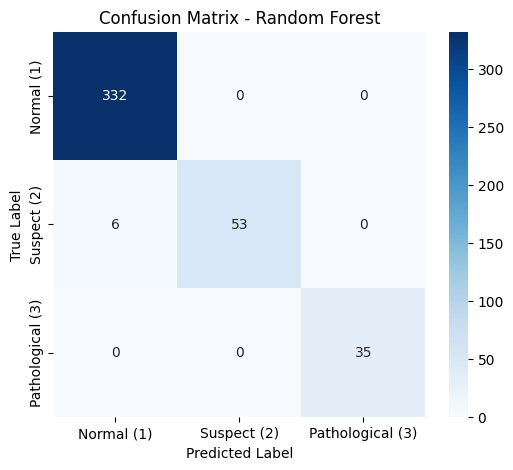

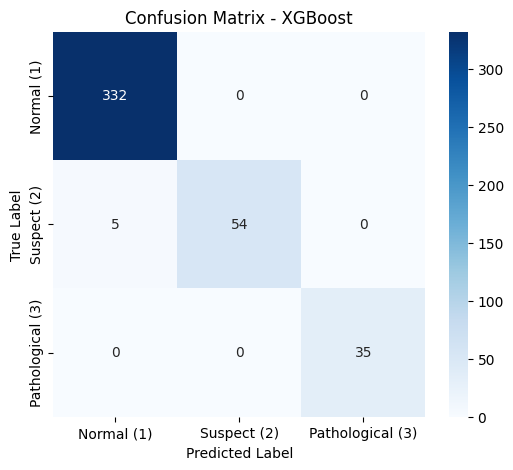

In [77]:
# ---------- CONFUSION MATRIX ----------
import seaborn as sns
def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Normal (1)', 'Suspect (2)', 'Pathological (3)']
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
plot_confusion(y_test, y_pred_rf, "Random Forest")
plot_confusion(y_test, y_pred_xgb, "XGBoost")

# ---------- FEATURE IMPORTANCE ----------
feature_names = X.columns
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

C:\Users\KIIT\AppData\Local\Temp\ipykernel_13120\4115852940.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:10], y=feature_names[sorted_idx][:10], palette="viridis")


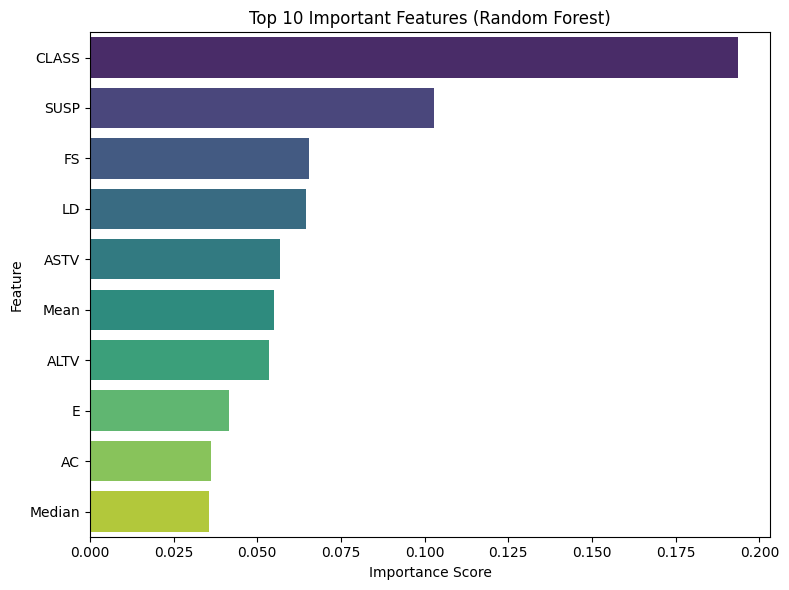

In [78]:
plt.figure(figsize=(8,6))
sns.barplot(x=importances[sorted_idx][:10], y=feature_names[sorted_idx][:10], palette="viridis")
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

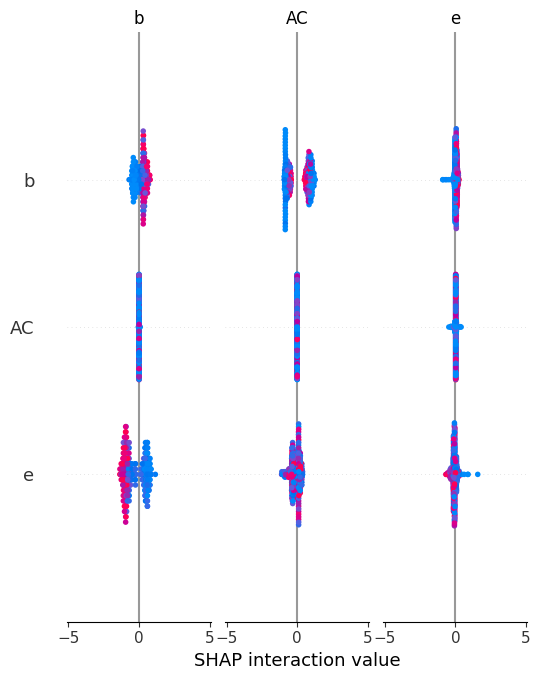

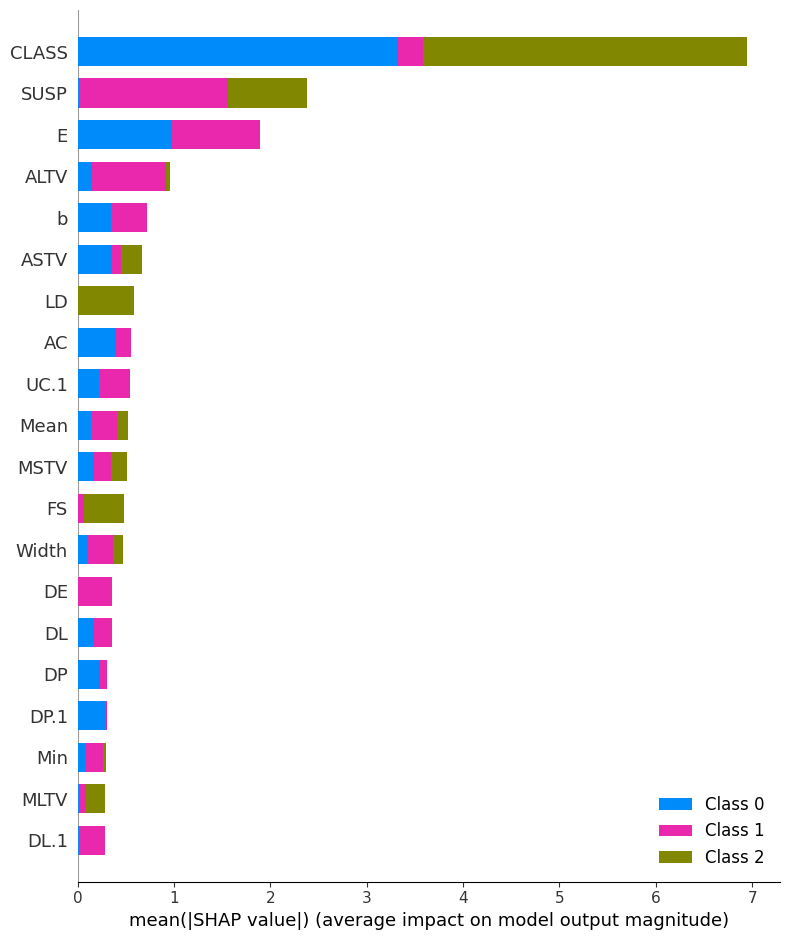

In [79]:
import shap
import joblib
# ---------- SHAP EXPLAINABILITY ----------
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")

In [81]:
# ---------- SAVE MODELS ----------
joblib.dump(rf, r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\ctg_randomforest_model.joblib")
joblib.dump(xgb_clf, r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\ctg_xgboost_model.joblib")
joblib.dump(scaler, r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\ctg_scaler.joblib")

print("\n✅ Models and scaler saved successfully.")


✅ Models and scaler saved successfully.
